### Texi guru challange appling random forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Recursive feature elemination
from sklearn.feature_selection import RFE

# Model
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# split of data features
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

# scoring of features
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
try: # For kaggle
  train_pd = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')

  test_pd = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
  print('running on kaggle')
except: #for local machine 
  print('running on local machine')
  train_pd = pd.read_csv('train.csv')
  test_pd = pd.read_csv('test.csv')
  pass
copy_train_pd = train_pd.copy()
copy_test_pd = test_pd.copy()
train_pd.info()

running on local machine
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amoun

### Exploratory Data Analysis
* removing all negative price 
* examining the data and unwanted values in the data frames
* examining the correlation between the variables

In [3]:
train_pd = copy_train_pd.copy()
x_train, x_test = train_test_split(train_pd, test_size= 0.2)
x_train_copy = x_train.copy()
x_test_copy = x_test.copy()

In [4]:
# x_train.drop(x_train[x_train['total_amount']<0].index, inplace=True)

In [5]:
print(f'''
unique values of passanger_count is: {x_train['passenger_count'].unique()}\n
unique values of RateCodeId is: {x_train['RatecodeID'].unique()}\n
unique values of store_and_fwd_flag is: {x_train['store_and_fwd_flag'].unique()}\n
unique values of congestion_surcharge is: {x_train['congestion_surcharge'].unique()}\n
unqiue values of airport_fees is: {x_train['Airport_fee'].unique()}\n
''')



unique values of passanger_count is: [ 1.  2.  4.  5.  6. nan  3.  0.  8.  9.]

unique values of RateCodeId is: [ 1.  2.  3. nan  5.  4. 99.]

unique values of store_and_fwd_flag is: ['N' nan 'Y']

unique values of congestion_surcharge is: [2.5 0.  nan]

unqiue values of airport_fees is: [0.   1.75  nan]




In [6]:
x_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,138638.000000,133717.000000,138638.000000,133717.000000,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,133717.000000,133717.000000
mean,0.725768,1.356447,5.532082,1.513099,132.728328,132.562595,1.965019,6.151629,0.655601,0.999397,30.190519,2.292023,0.162754
std,0.446952,0.891483,443.747209,6.486626,76.085586,76.248638,1.923695,4.455261,2.322775,0.022353,24.644732,0.690428,0.508265
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000275,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.090000,1.000000,67.000000,67.000000,0.000000,3.507245,0.000000,1.000000,16.400000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,132.000000,2.500000,5.322932,0.000000,1.000000,21.480000,2.500000,0.000000
75%,1.000000,1.000000,3.620000,1.000000,199.000000,199.000000,2.500000,7.526366,0.000000,1.000000,31.967500,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,184.313458,80.000000,1.000000,587.250000,2.500000,1.750000


<Axes: >

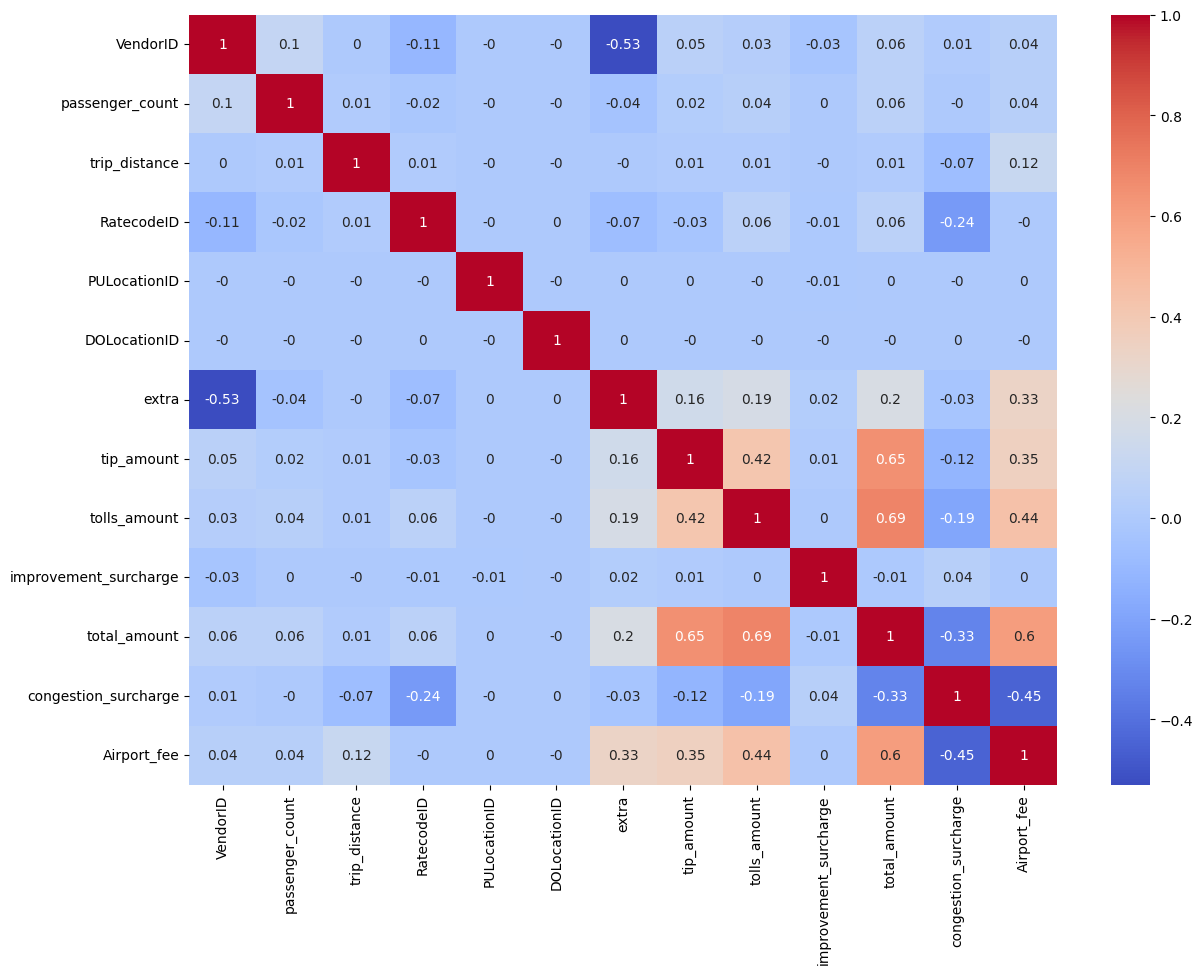

In [7]:
plt.figure(figsize=(14, 10))
sns.heatmap(x_train.corr(numeric_only= True).round(2), annot= True, cmap= 'coolwarm')

In [8]:
def convert_dt_obj_to_datetime(df:pd.DataFrame, col_name:str):
    df[col_name] = pd.to_datetime(df[col_name])
    df[col_name +'_Year'] = df[col_name].apply(lambda time: time.year)
    df[col_name +'_Month'] = df[col_name].apply(lambda time: time.month)
    df[col_name +'_Day'] = df[col_name].apply(lambda time: time.day)
    df[col_name +'_Hour'] = df[col_name].apply(lambda time: time.hour)
#     df[col_name +'_Minute'] = df[col_name].apply(lambda time: time.minute) # IGNORING MINS


In [9]:
x_train, x_test = x_train_copy.copy(), x_test_copy.copy()

convert_dt_obj_to_datetime(x_train, 'tpep_pickup_datetime')
convert_dt_obj_to_datetime(x_test, 'tpep_pickup_datetime')
# print('number of drop less than pickup',)
total_mis_matched_time =  len(x_train[x_train['tpep_dropoff_datetime'] < x_train['tpep_pickup_datetime']])
print(f'Number of rows which has the less greater pickup time than drop off{total_mis_matched_time}')
x_train = x_train.drop('tpep_pickup_datetime', axis= 1)
x_test = x_test.drop('tpep_pickup_datetime', axis= 1)

convert_dt_obj_to_datetime(x_train, 'tpep_dropoff_datetime')
convert_dt_obj_to_datetime(x_test, 'tpep_dropoff_datetime')

x_train = x_train.drop('tpep_dropoff_datetime', axis= 1)
x_test = x_test.drop('tpep_dropoff_datetime', axis= 1)

x_train.info()
x_train_copy, x_test_copy = x_train.copy(), x_test.copy()

Number of rows which has the less greater pickup time than drop off52513
<class 'pandas.core.frame.DataFrame'>
Index: 140000 entries, 84984 to 69492
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   VendorID                     140000 non-null  int64  
 1   passenger_count              135079 non-null  float64
 2   trip_distance                140000 non-null  float64
 3   RatecodeID                   135079 non-null  float64
 4   store_and_fwd_flag           135079 non-null  object 
 5   PULocationID                 140000 non-null  int64  
 6   DOLocationID                 140000 non-null  int64  
 7   payment_type                 140000 non-null  object 
 8   extra                        140000 non-null  float64
 9   tip_amount                   140000 non-null  float64
 10  tolls_amount                 140000 non-null  float64
 11  improvement_surcharge        140000 non-null  

In [10]:
cv_shuffle_20 = ShuffleSplit(n_splits= 20, test_size= 0.1)
cv_shuffle_5 = ShuffleSplit(n_splits= 5, test_size= 0.1)

In [11]:
x_train = x_train_copy.copy()
y_train = x_train['total_amount']
x_train = x_train.drop('total_amount', axis= 1)

x_test = x_test_copy.copy()
y_test = x_test['total_amount']
x_test = x_test.drop('total_amount', axis= 1)

In [12]:
com_train_features, dev_train_features, com_train_label, dev_train_label = train_test_split(x_train, y_train, test_size= 0.2)

In [13]:
vendor_id_pipe = Pipeline([
  ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore'))
])
passanger_count_pipe = Pipeline([
    ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= 1)),
    ('std_scaler', StandardScaler())
])

rate_code_id_pipe = Pipeline([
       ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant',
                                         fill_value= 1)),
       ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore')) ## TODO: experimental changes
])

store_and_fwd_pipe = Pipeline([
    ('simple_immmputer', SimpleImputer(missing_values= np.nan, strategy='constant', fill_value='N')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore'))
])
congestion_charger_pipe = Pipeline([
    ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= 0)),
    ('std_scaler', StandardScaler())
])

airport_fee_pipe = Pipeline([
    ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value= 0)),
    ('std_scale', StandardScaler())
])

payment_type_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore'))
])

In [14]:
feature_scaling_pipeline = ColumnTransformer([
  ('vendor_id', vendor_id_pipe, ['VendorID']),
  ('passanger_count', passanger_count_pipe, ['passenger_count']),
  ('rate_code_id', rate_code_id_pipe, ['RatecodeID']), # experimental changes
  ('s_nd_f_flag', store_and_fwd_pipe, ['store_and_fwd_flag']),
  ('pu_loc', StandardScaler(), ['PULocationID']),
  ('du_loc', StandardScaler(), ["DOLocationID"]),
  ('payment_t', payment_type_pipe, ['payment_type']),
  ('extra_t', StandardScaler(), ['extra']),
  ('tip_amount_t', StandardScaler(), ['tip_amount']),
  ('tolls_amount_t', StandardScaler(), ["tolls_amount"]),
  ('improvement_c', StandardScaler(), ['improvement_surcharge']),
  ('cong_charge', congestion_charger_pipe, ['congestion_surcharge']),
  ('Airport_fee_t', airport_fee_pipe, ['Airport_fee']),
  ('std_scaler', StandardScaler(), [i for i in range(14, 22)])
], remainder='passthrough')
feature_scaling_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('vendor_id',
                                 Pipeline(steps=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['VendorID']),
                                ('passanger_count',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(fill_value=1,
                                                                strategy='constant')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['passenger_count']),
                                ('rate_code_id',
                                 Pipeline(steps=[(...
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['congestion_surcharge']),
                                ('Airport_fee_t',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('std_scale',
                                                  StandardScaler())]),
                                 ['Airport_fee']),
                                ('std_scaler', StandardScaler(),
                                 [14, 15, 16, 17, 18, 19, 20, 21])])

In [15]:
model = Pipeline(steps= [
    ('feature_scaling', feature_scaling_pipeline),
    ('bagging', BaggingRegressor(n_estimators= 20, n_jobs= -1))
])
model

Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vendor_id',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['VendorID']),
                                                 ('passanger_count',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['passenger_count']...
                                                                                 strategy='constant')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['congestion_surcharge']),
                                                 ('Airport_fee_t',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std_scale',
                                                                   StandardScaler())]),
                                                  ['Airport_fee']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  [14, 15, 16, 17, 18, 19, 20,
                                                   21])])),
                ('bagging', BaggingRegressor(n_estimators=20, n_jobs=-1))])

In [16]:
# model.fit(com_train_features, com_train_label)
params = {
    'bagging__n_estimators': [5, 10, 15, 20],
    'bagging__max_samples': [0.8, 1.0],
    'bagging__bootstrap': [True, False],
    'bagging__n_jobs': [-1]
}
from sklearn.model_selection import GridSearchCV
model_gv= GridSearchCV(model, params, 
                       return_train_score= True, 
                       refit= True,
                       n_jobs= -1,
                       verbose= 3,
                       cv= cv_shuffle_5)

In [17]:
# model_gv.fit(x_train, y_train)
model.fit(x_train, y_train)

Pipeline(steps=[('feature_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vendor_id',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['VendorID']),
                                                 ('passanger_count',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['passenger_count']...
                                                                                 strategy='constant')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['congestion_surcharge']),
                                                 ('Airport_fee_t',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('std_scale',
                                                                   StandardScaler())]),
                                                  ['Airport_fee']),
                                                 ('std_scaler',
                                                  StandardScaler(),
                                                  [14, 15, 16, 17, 18, 19, 20,
                                                   21])])),
                ('bagging', BaggingRegressor(n_estimators=20, n_jobs=-1))])

In [18]:
# model_gv.best_params_

In [19]:
# model = model_gv.best_estimator_

In [20]:
from sklearn import tree
plt.figure(figsize= (28, 8), facecolor= 'w')
# tree_vz = tree.plot_tree(dt_pipeline[-1],
#                          feature_names= dt_pipeline[0].get_feature_names_out(),
#                          rounded= True,
#                          filled= True,
#                          fontsize= 12)

<Figure size 2800x800 with 0 Axes>

<Figure size 2800x800 with 0 Axes>

In [21]:
# from sklearn.tree import export_text 
# tree_rules = export_text(dt_pipeline[-1])
# print(tree_rules)


In [22]:
y_hat = model.predict(com_train_features)
r2_val = r2_score(com_train_label, y_hat)
print('r2 score of the dt is:', r2_val)

r2 score of the dt is: 0.9914852102823577


In [23]:
dev_y_hat = model.predict(dev_train_features)
r2_dev_score = r2_score(dev_train_label, dev_y_hat)
print('train score is:', r2_dev_score)

train score is: 0.9888986890976895


In [24]:
main_y_test = model.predict(x_test)
r2_main_test = r2_score(y_test, main_y_test)
print('main test score', r2_main_test)

main test score 0.9353072780725522


In [25]:
len(main_y_test[main_y_test < 0])

361

## submission code

In [26]:
# impute_unknown_values(test_pd)
convert_dt_obj_to_datetime(test_pd, 'tpep_pickup_datetime')
test_pd = test_pd.drop('tpep_pickup_datetime', axis= 1)

convert_dt_obj_to_datetime(test_pd, 'tpep_dropoff_datetime')
test_pd = test_pd.drop('tpep_dropoff_datetime', axis= 1)


In [27]:
test_pd_prediction = model.predict(test_pd)

In [28]:
submission = pd.DataFrame(columns= ['ID', "total_amount"])
submission['ID'] = [i for i in range(1, 50001)]
submission['total_amount'] = test_pd_prediction
submission.to_csv('submission.csv', index=False)

In [29]:
submission.describe()

,ID,total_amount
count,50000.000000,50000.000000
mean,25000.500000,29.615911
std,14433.901067,24.590378
min,1.000000,-135.133000
25%,12500.750000,16.741500
50%,25000.500000,21.572500
75%,37500.250000,31.595625
max,50000.000000,517.160000


In [30]:
submission[submission['total_amount'] < 0]

,ID,total_amount
12,13,-4.5350
99,100,-42.5375
133,134,-14.0250
199,200,-14.3050
419,420,-25.2000
...,...,...
49639,49640,-52.4325
49714,49715,-10.2705
49741,49742,-12.8150
49858,49859,-7.0000
